# Init

In [1]:
%cd /kaggle/input/leaves

/kaggle/input/leaves


In [2]:
!pip install -q keras-tuner --upgrade
import keras_tuner as kt

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import cv2 as cv

import skimage as ski
import skimage.filters as skif
import skimage.color as skic

from sklearn.utils import class_weight



# -------------------------------------

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)



# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)



# Dataset folders 
dataset_dir = '/kaggle/input/leaves'
training_dir = os.path.join(dataset_dir, 'training')

2.6.0


In [4]:
tresh_data_gen = ImageDataGenerator(validation_split=0.2,
                                    rotation_range=45,
                                    zoom_range=0.3,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    fill_mode='constant')
valid_data_gen = ImageDataGenerator(validation_split=0.2)


train_gen = tresh_data_gen.flow_from_directory(directory = training_dir,
                                                 subset = 'training',
                                                 target_size=(240,240),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='categorical',
                                                 batch_size=8,
                                                 shuffle=True,
                                                 seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory = training_dir,
                                                 subset = 'validation',
                                                 target_size=(240,240),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='categorical',
                                                 batch_size=8,
                                                 shuffle=False,
                                                 seed=seed)

labels = (train_gen.class_indices)
inv_labels = {v: k for k, v in labels.items()}
print(inv_labels)

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.
{0: 'Apple', 1: 'Blueberry', 2: 'Cherry', 3: 'Corn', 4: 'Grape', 5: 'Orange', 6: 'Peach', 7: 'Pepper', 8: 'Potato', 9: 'Raspberry', 10: 'Soybean', 11: 'Squash', 12: 'Strawberry', 13: 'Tomato'}


In [5]:
def to_categorical(image, label):
    # Casts to an Int and performs one-hot ops
    label = tf.one_hot(tf.cast(label, tf.int32), 14)
    # Recasts it to Float32
    label = tf.cast(label, tf.float32)
    return image, label

train_ds = tfk.utils.image_dataset_from_directory(
        training_dir, 
        labels='inferred',
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=(240, 240),
        batch_size=8)
data_aug = tfk.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical", seed=seed),
    tfkl.RandomRotation(0.2, fill_mode='constant', seed=seed),
    tfkl.RandomZoom(0.3, fill_mode='constant', seed=seed)
])
train_ds = train_ds.map(to_categorical)
train_ds_aug = train_ds.map(lambda x, y: (data_aug(x,training=True), y),  num_parallel_calls=tf.data.AUTOTUNE)


valid_ds = tfk.utils.image_dataset_from_directory(
        training_dir, 
        labels='inferred',
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=(240, 240),
        batch_size=8)
valid_ds = valid_ds.map(to_categorical)

Found 17728 files belonging to 14 classes.
Using 14183 files for training.


2021-11-24 15:16:51.016127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 15:16:51.153865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 15:16:51.155030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 15:16:51.158327: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 17728 files belonging to 14 classes.
Using 3545 files for validation.


In [6]:
print(inv_labels.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])


In [7]:
keys = range(14)
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_gen.classes), 
                train_gen.classes)

weights = dict(zip(keys,class_weights))
print(weights)

{0: 1.2812895069532237, 1: 2.7098930481283423, 2: 2.170235546038544, 3: 1.050259067357513, 4: 0.8684661525278492, 5: 0.724446032880629, 6: 1.2960358056265984, 7: 1.6560457516339868, 8: 1.768760907504363, 9: 4.78066037735849, 10: 0.7838360402165506, 11: 2.2032608695652174, 12: 1.8803339517625233, 13: 0.2225027442371021}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13], y=[ 0  0  0 ... 13 13 13] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# Data Visualization _from generator_

## valid_gen

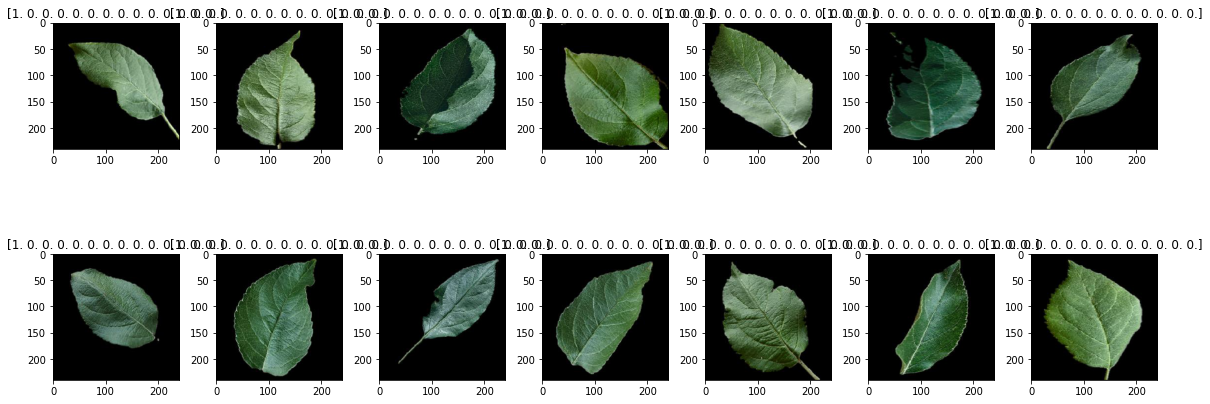

In [8]:
num_row = 2
num_col = 7
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,num_col))


for i in range(num_row*num_col):
  if i < (num_row*num_col):
    
    img_batch, label = valid_gen.next()   #label is useless
    img = img_batch[0]    
    img/=255
#     img[:,:,1]=0
#     img[:,:,2]=0
    
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))

    ax.set_title('{}'.format(label[0]))
plt.tight_layout()
plt.show()

## train_gen

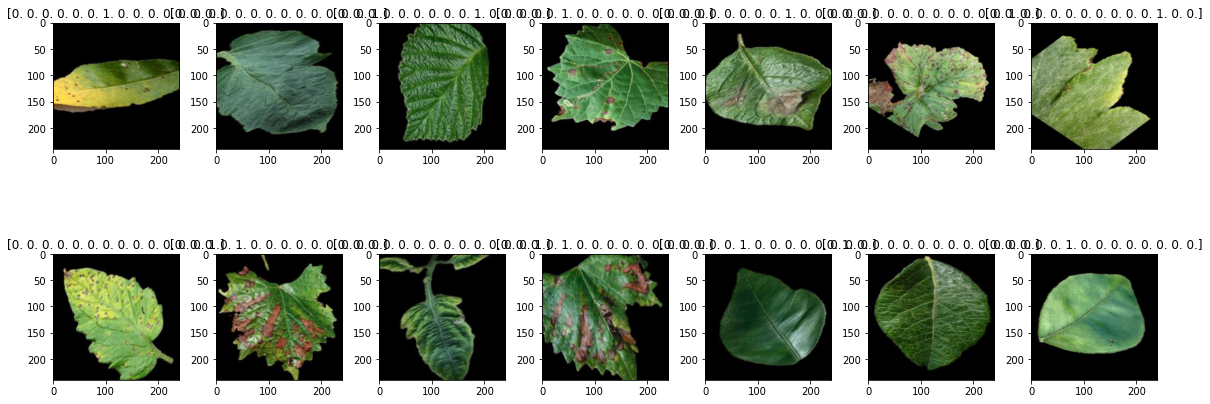

In [9]:
num_row = 2
num_col = 7
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,num_col))


for i in range(num_row*num_col):
  if i < (num_row*num_col):
    
    img_batch, label = train_gen.next()   #label is useless
    img = img_batch[0]  
    img/=255
#     img[:,:,1]=0
#     img[:,:,2]=0
    
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))

    ax.set_title('{}'.format(label[0]))
plt.tight_layout()
plt.show()

# __Model__

In [10]:
input_shape = (240, 240, 3)

In [11]:
###TODO Transfer Learning EfficientNetB5

# from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB1
# from tensorflow.keras.applications.efficientnet import EfficientNetB2
# from tensorflow.keras.applications.efficientnet import EfficientNetB4

supernet = EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    classifier_activation='softmax'
)

# supernet.summary()
#tfk.utils.plot_model(supernet)

supernet.trainable = False

27033600/27018416 [==============================] - 0s 0us/step


In [12]:
def add_conv1_block(model, filters, activation='relu', dropout=0.3):
    model.add(tfkl.Conv2D(filters=filters, kernel_size=1, strides=1))
    model.add(tfkl.Dropout(dropout))
    model.add(tfkl.BatchNormalization())
    if activation!=None:
        model.add(tfkl.Activation(activation))
    

In [13]:
# Compile the model
def hypermodel(hp):
    model = tfk.Sequential()
    
    #input & supernet
    model.add(tfkl.Input(shape=input_shape))
    model.add(supernet)
    
    hp_dropout = hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5, 0.6])
    
    #hiddens
    hp_filters1 = hp.Int('filters', min_value=512, max_value=768, step=64)
    add_conv1_block(model=model, filters=hp_filters1, dropout=hp_dropout)
    
    hp_filters2 = hp.Int('filters2', min_value=160, max_value=224, step=16)
    add_conv1_block(model=model, filters=hp_filters2, dropout=hp_dropout)
    
    hp_filters2 = hp.Int('filters3', min_value=24, max_value=48, step=8)
    add_conv1_block(model=model, filters=hp_filters2, dropout=hp_dropout)
    
    
    #output
    add_conv1_block(model=model, filters=14, activation=None, dropout=hp_dropout)
    model.add(tfkl.GlobalMaxPooling2D())
    model.add(tfkl.Activation('softmax'))
    
    
    ###
    
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    hp_loss = hp.Choice('loss', values=['categorical_crossentropy',
                                        'kl_divergence'])
#                                         ''
#                                         tfk.losses.CosineSimilarity(),
#                                         tfk.losses.CategoricalHinge()
                                       
#     loss = tfk.losses.CategoricalCrossentropy()

    model.compile(loss=hp_loss, optimizer=optimizer, metrics=['accuracy'])
#     model.summary()
    
    return model

print('ok')

ok


In [14]:
%cd /kaggle/working

/kaggle/working


In [15]:
### TUNER

# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=10, 
#                      factor=3,
#                      directory='tuning',
#                      project_name='ENB1_fullyconv',
#                      hp)

stop_early = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
tuner = kt.RandomSearch(hypermodel,
                        objective='val_accuracy',
                        executions_per_trial=1, 
                        directory='tuning', 
                        project_name='hyperparam-tune')
print('ok')

ok


In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dropout_rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5, 0.6], 'ordered': True}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 768, 'step': 64, 'sampling': None}
filters2 (Int)
{'default': None, 'conditions': [], 'min_value': 160, 'max_value': 224, 'step': 16, 'sampling': None}
filters3 (Int)
{'default': None, 'conditions': [], 'min_value': 24, 'max_value': 48, 'step': 8, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.005, 0.001], 'ordered': True}
loss (Choice)
{'default': 'categorical_crossentropy', 'conditions': [], 'values': ['categorical_crossentropy', 'kl_divergence'], 'ordered': False}


In [18]:
tuner.search(x = train_ds,   
            epochs = 5,
            validation_data = valid_ds,   
            callbacks = [stop_early])

Trial 10 Complete [00h 10m 24s]
val_accuracy: 0.9681240916252136

Best val_accuracy So Far: 0.9732016921043396
Total elapsed time: 01h 43m 23s


In [19]:
models = tuner.get_best_models(num_models=2)

In [20]:
tuner.results_summary()

Results summary
Results in tuning/hyperparam-tune
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_rate: 0.3
filters: 704
filters2: 176
filters3: 40
learning_rate: 0.005
loss: kl_divergence
Score: 0.9732016921043396
Trial summary
Hyperparameters:
dropout_rate: 0.4
filters: 704
filters2: 176
filters3: 32
learning_rate: 0.001
loss: categorical_crossentropy
Score: 0.9681240916252136
Trial summary
Hyperparameters:
dropout_rate: 0.3
filters: 640
filters2: 208
filters3: 32
learning_rate: 0.001
loss: categorical_crossentropy
Score: 0.9633286595344543
Trial summary
Hyperparameters:
dropout_rate: 0.3
filters: 576
filters2: 160
filters3: 40
learning_rate: 0.001
loss: categorical_crossentropy
Score: 0.9610719084739685
Trial summary
Hyperparameters:
dropout_rate: 0.4
filters: 640
filters2: 208
filters3: 32
learning_rate: 0.005
loss: kl_divergence
Score: 0.9472496509552002
Trial summary
Hyperparameters:
dropout_rate: 0.5
filters: 768
filt